In [48]:
from __future__ import annotations
from typing import List, Tuple, Sequence, Optional
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

from voronoi_site_suite import load_sites_cases, generate_sites

In [122]:
Point  = Tuple[float, float]
WPoint = Tuple[int, int, int]

# ---------- view limiting parameters ----------
_MIN_EXPAND = 1.2            # lower bound of span vs. sites-only span
_MAX_EXPAND = 3.0            # upper bound of span vs. sites-only span
_GLOBAL_MIN_CORNER = (-2000.0, -2000.0)   # clamp lower-left corner

# ---------- geometry ----------
def _area2(poly: Sequence[Point]) -> float:
    s = 0.0
    for i in range(len(poly)):
        x1,y1 = poly[i]; x2,y2 = poly[(i+1)%len(poly)]
        s += x1*y2 - y1*x2
    return s

def _ensure_ccw(poly: List[Point]) -> List[Point]:
    return list(reversed(poly)) if len(poly)>=3 and _area2(poly)<0 else poly

def _power_bisector_line(si: WPoint, sj: WPoint) -> Tuple[float,float,float]:
    xi, yi, wi = si; xj, yj, wj = sj
    a = 2.0*(xj-xi); b = 2.0*(yj-yi)
    c = (xj*xj+yj*yj) - (xi*xi+yi*yi) + (wi-wj)
    return a, b, c

def _clip_polygon_with_halfplane(poly: List[Point], a: float, b: float, c: float, eps: float=1e-9) -> List[Point]:
    if not poly: return []
    def inside(P): return a*P[0]+b*P[1] <= c+eps
    def intersect(P,Q):
        u = a*P[0]+b*P[1]-c; v = a*Q[0]+b*Q[1]-c
        den = u-v
        if abs(den)<1e-15: return Q
        t = u/den
        return (P[0]+t*(Q[0]-P[0]), P[1]+t*(Q[1]-P[1]))
    out: List[Point] = []
    n = len(poly)
    for i in range(n):
        S = poly[i]; E = poly[(i+1)%n]
        Si, Ei = inside(S), inside(E)
        if   Si and Ei: out.append(E)
        elif Si and not Ei: out.append(intersect(S,E))
        elif (not Si) and Ei: out.append(intersect(S,E)); out.append(E)
    cleaned: List[Point] = []
    for p in out:
        if not cleaned or (abs(cleaned[-1][0]-p[0])>1e-12 or abs(cleaned[-1][1]-p[1])>1e-12):
            cleaned.append(p)
    if len(cleaned)>=2 and abs(cleaned[0][0]-cleaned[-1][0])<1e-12 and abs(cleaned[0][1]-cleaned[-1][1])<1e-12:
        cleaned.pop()
    return cleaned

# ---------- finite power vertices for auto view ----------
def _power_vertex_from_triplet(si: WPoint, sj: WPoint, sk: WPoint) -> Optional[Point]:
    a1,b1,c1 = _power_bisector_line(si,sj); a2,b2,c2 = _power_bisector_line(si,sk)
    det = a1*b2 - a2*b1
    if abs(det)<1e-12: return None
    x = (c1*b2 - c2*b1)/det; y = (a1*c2 - a2*c1)/det
    return (x,y)

def _power_value(p: Point, s: WPoint) -> float:
    x,y = p; xi,yi,wi = s
    return (x-xi)*(x-xi) + (y-yi)*(y-yi) - wi

def _finite_power_vertices(sites: Sequence[WPoint], eps: float=1e-9) -> List[Point]:
    verts: List[Point] = []
    n = len(sites)
    for i,j,k in itertools.combinations(range(n),3):
        p = _power_vertex_from_triplet(sites[i],sites[j],sites[k])
        if p is None or not math.isfinite(p[0]) or not math.isfinite(p[1]): continue
        pv = _power_value(p, sites[i])
        if abs(pv-_power_value(p,sites[j]))>1e-6 or abs(pv-_power_value(p,sites[k]))>1e-6: continue
        ok = True
        for t in range(n):
            if t in (i,j,k): continue
            if pv - _power_value(p, sites[t]) > eps: ok=False; break
        if ok: verts.append(p)
    return verts

def _bbox_points(pts: Sequence[Point]) -> Optional[Tuple[float,float,float,float]]:
    if not pts: return None
    xs=[p[0] for p in pts]; ys=[p[1] for p in pts]
    return (min(xs),min(ys),max(xs),max(ys))

def _expand_to_square(box: Tuple[float,float,float,float], margin_ratio: float) -> Tuple[float,float,float,float]:
    xmin,ymin,xmax,ymax = box
    cx=0.5*(xmin+xmax); cy=0.5*(ymin+ymax)
    span=max(xmax-xmin, ymax-ymin); span = span if span>0 else 1.0
    span *= (1.0+margin_ratio)
    return (cx-span/2, cy-span/2, cx+span/2, cy+span/2)

def _sites_square(sites: Sequence[WPoint], margin_ratio: float=0.20) -> Tuple[float,float,float,float]:
    xs=[float(x) for x,_,_ in sites]; ys=[float(y) for _,y,_ in sites]
    return _expand_to_square((min(xs),min(ys),max(xs),max(ys)), margin_ratio)

# ---------- robust center computation ----------
def _coord_median(vals: List[float]) -> float:
    s = sorted(vals); m = len(s)//2
    return s[m] if len(s)%2==1 else 0.5*(s[m-1]+s[m])

def _weiszfeld(points: List[Point], iters: int=50, eps: float=1e-8) -> Point:
    # geometric median (approx), start at centroid
    x0 = sum(p[0] for p in points)/len(points)
    y0 = sum(p[1] for p in points)/len(points)
    x,y = x0,y0
    for _ in range(iters):
        numx=numy=den=0.0
        stuck=False
        for px,py in points:
            dx=x-px; dy=y-py
            d = math.hypot(dx,dy)
            if d < eps:
                # at a data point: this point is a geometric median
                x,y = px,py
                stuck=True
                break
            w = 1.0/d
            numx += w*px; numy += w*py; den += w
        if stuck: break
        nx, ny = numx/den, numy/den
        if math.hypot(nx-x, ny-y) < eps: 
            x,y = nx,ny; break
        x,y = nx,ny
    return (x,y)

def _robust_center(sites: Sequence[WPoint]) -> Point:
    pts = [(float(x),float(y)) for x,_,y in [(s[0], s[1], s[1]) for s in sites]]  # dummy to avoid confusion
    pts = [(float(x), float(y)) for (x,y,_) in sites]
    xs = [p[0] for p in pts]; ys = [p[1] for p in pts]
    centroid = (sum(xs)/len(xs), sum(ys)/len(ys))
    median    = (_coord_median(xs), _coord_median(ys))
    gmed      = _weiszfeld(pts)
    # weight by |w| (robust floor) to emphasize dense/important regions
    w0 = 10.0
    ws = [max(abs(w), w0) for (_,_,w) in sites]
    wsum = sum(ws)
    wcent = (sum(ws[i]*xs[i] for i in range(len(xs)))/wsum,
             sum(ws[i]*ys[i] for i in range(len(ys)))/wsum)
    # blended center: average of the four
    cx = 0.25*(centroid[0] + median[0] + gmed[0] + wcent[0])
    cy = 0.25*(centroid[1] + median[1] + gmed[1] + wcent[1])
    return (cx, cy)

# ---------- clamped auto view using robust center ----------
def _auto_view_from_cells_clamped(sites: Sequence[WPoint]) -> Tuple[float,float,float,float]:
    # base from sites only
    bxmin,bymin,bxmax,bymax = _sites_square(sites, 0.20)
    bspan = max(bxmax-bxmin, bymax-bymin)

    # candidate from finite vertices ∪ sites
    verts = _finite_power_vertices(sites)
    pts = verts + [(float(x),float(y)) for (x,y,_) in sites]
    box = _bbox_points(pts) or (bxmin,bymin,bxmax,bymax)
    vxmin,vymin,vxmax,vymax = _expand_to_square(box, 0.20)
    vspan = max(vxmax-vxmin, vymax-vymin)

    # clamp span
    span = min(max(vspan, _MIN_EXPAND*bspan), _MAX_EXPAND*bspan)

    # robust center
    cx, cy = _robust_center(sites)

    xmin, ymin = cx - span/2, cy - span/2
    xmax, ymax = cx + span/2, cy + span/2

    # enforce global lower-left clamp
    gminx, gminy = _GLOBAL_MIN_CORNER
    if xmin < gminx:
        shift = gminx - xmin
        xmin += shift; xmax += shift
    if ymin < gminy:
        shift = gminy - ymin
        ymin += shift; ymax += shift

    return (xmin, ymin, xmax, ymax)

def _view_polygon(view: Tuple[float,float,float,float]) -> List[Point]:
    xmin,ymin,xmax,ymax = view
    return [(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)]

# ---------- main ----------
def build_power_diagram_figure(sites_in: Sequence[WPoint], ensure_ccw: bool=True) -> plt.Figure:
    if sites_in is None or len(sites_in)<2: raise ValueError("need at least 2 sites")
    Ss: List[WPoint] = []; seen=set()
    for x,y,w in sites_in:
        for v in (x,y,w):
            if not (isinstance(v,(int,float)) and math.isfinite(v)): raise ValueError("non-finite")
        key=(int(x),int(y),int(w))
        if key in seen: continue
        seen.add(key); Ss.append((int(x),int(y),int(w)))
    n=len(Ss)

    view = _auto_view_from_cells_clamped(Ss)
    Vpoly0 = _view_polygon(view)
    xmin,ymin,xmax,ymax = view
    span = max(xmax-xmin, ymax-ymin)

    # cells via half-plane clipping
    cells: List[List[Point]] = []
    for i in range(n):
        poly = Vpoly0[:]
        for j in range(n):
            if j==i: continue
            a,b,c = _power_bisector_line(Ss[i], Ss[j])
            poly = _clip_polygon_with_halfplane(poly,a,b,c,eps=1e-9)
            if not poly: break
        if poly and ensure_ccw: poly=_ensure_ccw(poly)
        cells.append(poly)

    # render
    fig = plt.figure(figsize=(5,5), dpi=160, facecolor="white")
    ax  = fig.add_subplot(111)
    ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([]); ax.set_yticks([])
    for s in ("top","right","left","bottom"): ax.spines[s].set_visible(False)

    # circles below edges
    D = span; r_base = 0.05*D; w0 = 10.0
    pos_style = (0,(1,2))             # positive: dotted
    neg_style = (0,(6,2,1,2))         # negative: dash-dot-dot
    for (x,y,w) in Ss:
        mag = max(abs(w), w0); r = r_base*math.sqrt(mag/w0)
        face = (0.7,0.7,0.7,0.15) if w>=0 else (1,1,1,0.15)
        ls   = pos_style if w>=0 else neg_style
        ax.add_patch(Circle((x,y), r, facecolor=face, edgecolor="black",
                            linewidth=0.5, linestyle=ls, zorder=1))

    # cell boundaries on top
    for poly in cells:
        if len(poly)>=2:
            xs=[p[0] for p in poly]+[poly[0][0]]
            ys=[p[1] for p in poly]+[poly[0][1]]
            ax.plot(xs,ys,linestyle='-',color='black',linewidth=1.5,zorder=3)

    # sites on top-most
    ax.scatter([x for x,_,_ in Ss],[y for _,y,_ in Ss], s=10, c="black", zorder=4)

    # white overlay to hide any residual axis border
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                           fill=False, edgecolor="white", linewidth=8,
                           zorder=10, clip_on=False))

    # compact label just below the square
    label = f"({int(xmin)},{int(ymin)}) -> ({int(xmax)},{int(ymax)})  edge={int(round(span))}"
    ax.text(xmin, ymin - 0.015*span, label, ha="left", va="top",
            fontsize=8, color="black", clip_on=False)

    return fig

In [105]:
Sites = load_sites_cases()   

In [89]:
Site1, Site2, Site3 = Sites

In [90]:
Site2

[(500, 500, 5000),
 (560, 500, 10),
 (440, 500, 10),
 (500, 560, 10),
 (500, 440, 10),
 (200, 500, 1000),
 (800, 500, 1000),
 (500, 200, 1000),
 (500, 800, 1000),
 (100, 900, -200)]

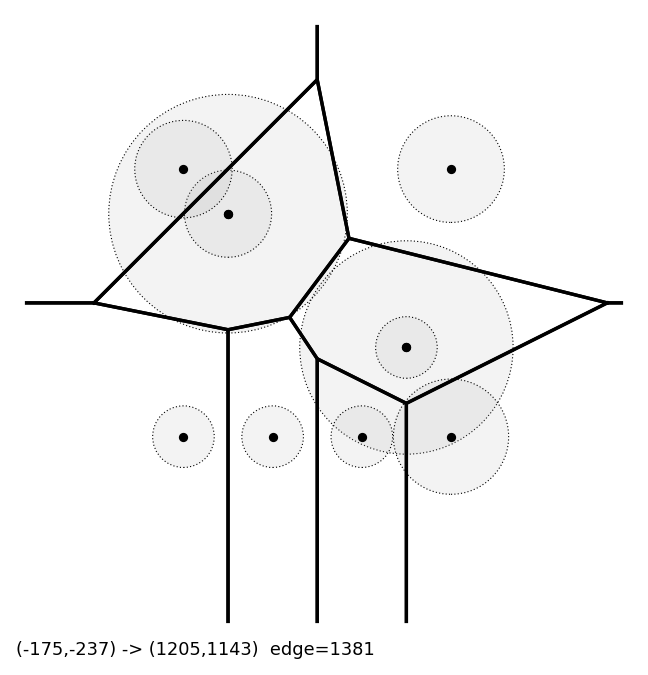

In [132]:
fig = build_power_diagram_figure(Site3)

In [92]:
TestSites = generate_sites([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [93]:
TestSite1, TestSite2, TestSite3, TestSite4, TestSite5, TestSite6, TestSite7, TestSite8, TestSite9 = TestSites

In [94]:
TestSite1

[(816, 19, 1),
 (330, 849, -76),
 (525, 374, -577),
 (397, 813, -343),
 (816, 398, -3),
 (446, 485, 3),
 (863, 943, 4),
 (90, 36, -284),
 (104, 370, -5),
 (379, 948, -3)]

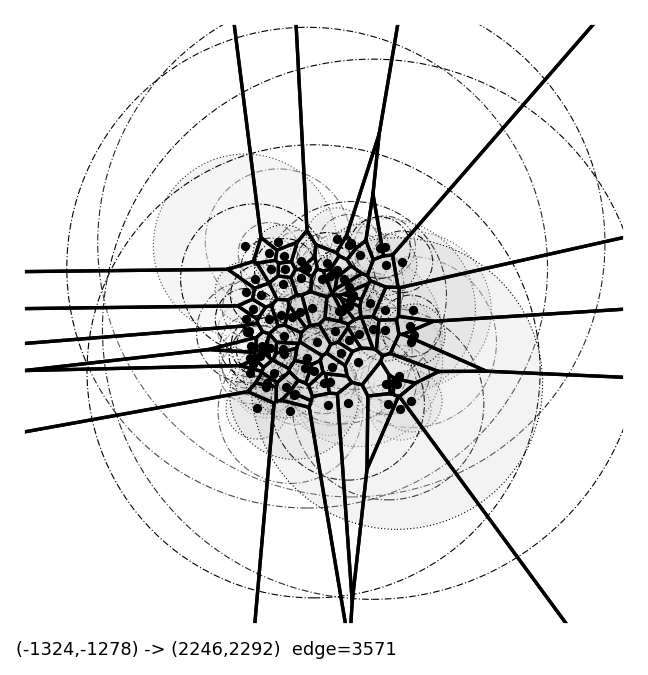

In [137]:
fig = build_power_diagram_figure(TestSite9)